In [1]:
from __future__ import print_function
import six

In [2]:
import yaml
import numpy
import pandas
import toyplot.pdf

print("yaml version:    ", yaml.__version__)
print("numpy version:   ", numpy.__version__)
print("pandas version:  ", pandas.__version__)
print("toyplot version: ", toyplot.__version__)

yaml version:     3.12
numpy version:    1.13.1
pandas version:   0.20.3
toyplot version:  0.15.1


Load the data, which has already been processed into a YAML file.

In [3]:
yaml_data = yaml.load(file('external-faces-log-knl-2017-04-13.yaml', 'r'))
data = pandas.DataFrame(yaml_data)
#data.head(5)

In [4]:
print('Host:         ', data['hostname'][0])
print('VTK-m version:', data['vtkm-version'][0])

Host:          node03.bowman.sandia.gov
VTK-m version: 1.0.0-1140-g451930f


The YAML data is hierarchical. The basic yaml reader to DataFrame just embeds dictionaries and lists in DataFrame columns. Fix that by expanding the data of these columns into new columns.

In [5]:
def expand_single_column(original_data, column_to_expand):
    expanded_data = pandas.DataFrame()
    for index in original_data.index:
        sub_table = pandas.DataFrame(original_data[column_to_expand][index])
        for column in original_data.columns:
            if column != column_to_expand:
                sub_table[column] = numpy.full(sub_table.index.shape,
                                               original_data[column][index],
                                               dtype=original_data[column].dtype)
        expanded_data = expanded_data.append(sub_table, ignore_index=True)
    return expanded_data

def expand_columns(original_data, columns_to_expand):
    if isinstance(columns_to_expand, six.string_types):
        return expand_single_column(original_data, columns_to_expand)
    else:
        expanded_data = original_data
        for column in columns_to_expand:
            expanded_data = expand_single_column(expanded_data, column)
        return expanded_data

In [6]:
flat_data = expand_columns(data, ['experiments', 'trials'])
#flat_data.columns

Rename the algorithms to match those in the paper.

In [7]:
flat_data['full-name'].replace('Sort Id3', 'SortByID', inplace=True)
flat_data['full-name'].replace('Sort XOR Indices', 'Sort+XOR', inplace=True)
flat_data['full-name'].replace('Sort FNV1A', 'Sort+FNV1a', inplace=True)
flat_data['full-name'].replace('Sort Morton', 'Sort+Morton', inplace=True)
flat_data['full-name'].replace('Hash Fight XOR Indices', 'Hash-Fight+XOR', inplace=True)
flat_data['full-name'].replace('Hash Fight FNV1A', 'Hash-Fight+FNV1a', inplace=True)
flat_data['full-name'].replace('Hash Fight Morton', 'Hash-Fight+Morton', inplace=True)

## Compare hash functions per grid

In this section we are going to pick a particular input grid and compare the (average) time that each has function and algorithm takes to complete. To do this, we first create a pivot table that aggregates the data based on these collections.

In [8]:
pivot_data = \
    flat_data.pivot_table(values='seconds-total', 
                          index='full-name',
                          columns=['size-x', 'topology-connections'],
                          aggfunc='mean')

ordered_names = ['SortByID',
                 'Sort+XOR',
                 'Sort+FNV1a',
                 'Sort+Morton',
                 'Hash-Fight+XOR',
                 'Hash-Fight+FNV1a',
                 'Hash-Fight+Morton']
pivot_data = pivot_data.reindex(ordered_names)

pivot_data

size-x                      100                  128                  150  \
topology-connections randomized   regular randomized   regular randomized   
full-name                                                                   
SortByID               2.560596  1.448298   3.968734  2.529182   7.041264   
Sort+XOR               1.365375  0.811355   2.400223  1.271395   3.752226   
Sort+FNV1a             1.490556  1.458017   2.188653  2.195232   3.527317   
Sort+Morton            1.284482  1.003613   1.821054  1.582997   2.893390   
Hash-Fight+XOR         1.693952  1.450015   2.943017  2.116739   3.791591   
Hash-Fight+FNV1a       0.495486  0.449068   0.876275  0.789807   1.255844   
Hash-Fight+Morton      0.594297  0.497902   1.593680  1.382244   1.423362   

size-x                                175                  200            \
topology-connections   regular randomized   regular randomized   regular   
full-name                                                                  
SortByID              3.741841  10.765060  5.736095  14.866980  8.268528   
Sort+XOR              1.784699   5.866252  2.568232   7.578793  3.670228   
Sort+FNV1a            3.127488   5.680652  5.416914   8.210778  8.005662   
Sort+Morton           2.054376   4.362989  3.066874   5.817592  4.594779   
Hash-Fight+XOR        3.220150   5.100436  4.152327   9.089320  6.127893   
Hash-Fight+FNV1a      1.076397   1.773106  1.589751   2.460550  2.003640   
Hash-Fight+Morton     1.166549   2.128411  1.753702   2.667807  2.134074   

size-x                  ...            256                   275             \
topology-connections    ...     randomized    regular randomized    regular   
full-name               ...                                                   
SortByID                ...      29.416820  16.969680  32.370290  21.100240   
Sort+XOR                ...      15.672250   6.952278  19.426290   8.730318   
Sort+FNV1a              ...      14.590000  12.927240  18.105110  19.106490   
Sort+Morton             ...      12.123500   9.504826  14.529590  10.406810   
Hash-Fight+XOR          ...      19.042750   9.835029  17.473050  12.239210   
Hash-Fight+FNV1a        ...       4.661671   3.683638   5.687718   4.561830   
Hash-Fight+Morton       ...       9.736123   7.155372   6.692330   5.055728   

size-x                      300                   325                   350  \
topology-connections randomized    regular randomized    regular randomized   
full-name                                                                     
SortByID              48.010130  26.540760  66.208450  44.961240   75.60977   
Sort+XOR              25.363260  11.294890  31.996520  14.148230   40.87483   
Sort+FNV1a            23.886630  26.173320  33.223450  29.668550   37.76520   
Sort+Morton           19.854010  13.388330  25.063180  14.487050   32.85951   
Hash-Fight+XOR        25.607890  16.642660  35.133940  19.272900   34.90904   
Hash-Fight+FNV1a       7.195496   5.720451   9.086332   7.190357   11.27750   
Hash-Fight+Morton      8.157950   6.099042  10.781940   8.023520   13.47153   

size-x                           
topology-connections    regular  
full-name                        
SortByID              74.938990  
Sort+XOR              17.805530  
Sort+FNV1a            34.979130  
Sort+Morton           21.422540  
Hash-Fight+XOR        25.720120  
Hash-Fight+FNV1a       8.807724  
Hash-Fight+Morton      9.863428  

[7 rows x 22 columns]

The following function is a convenient way to make a table for a given grid size/topology.

In [9]:
def make_table(size, topology):
    time_data = pandas.DataFrame({'Algorithm':ordered_names,
                                  'Seconds':pivot_data[size][topology],
                                  'Seconds2':pivot_data[size][topology]})
    
    canvas = toyplot.Canvas(width='9in', height='3in')
    table = canvas.table(time_data,
                         label='{}<sup>3</sup> Grid, {} Topology'.format(size, topology))
    table.top.cell[0,1:3].merge().data = 'Time (seconds)'
    table.body.column[0].align = 'left'
    table.body.column[1].format = toyplot.format.FloatFormatter('{:.1f}s')

    table.body.column[0].width = '1.4in'
    table.body.column[1].width = '0.5in'

    axes = table.body.column[2].cartesian()
    axes.cell_bars(width=1.0)
    
    return canvas

There are a lot of mesh sizes that we computed, so let's just start with the smallest grids first.

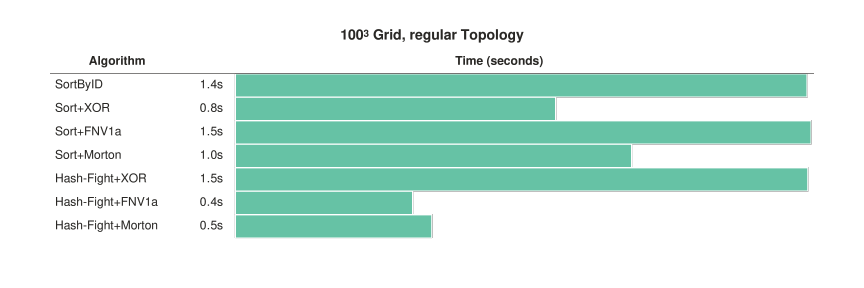

In [10]:
make_table(100, 'regular')

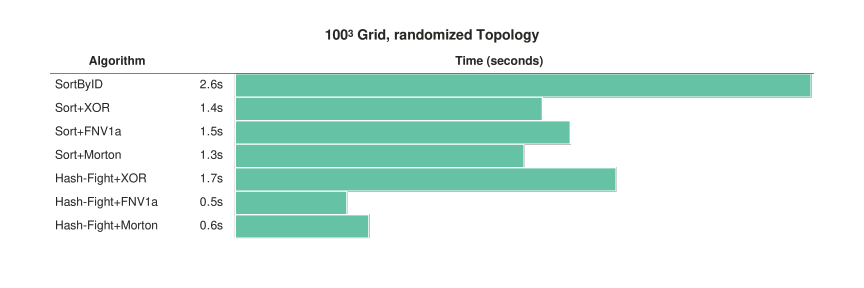

In [11]:
make_table(100, 'randomized')

From these measurements, it looks like the hash fight approach is out performing the sorting approach by a good margin. With the hash fight the FNV1A is beating out the XOR indices, which is what we would expect. But oddly, for the sorting approach it looks like XOR is beating FNV1A, which is very counterintuitive. For regular grids, FNV1A performs horribly. I wonder what is going on there. XOR is even beating Morton codes for the regular grid. This must be because it takes less time to compute.

Next we look at the largeset grids.

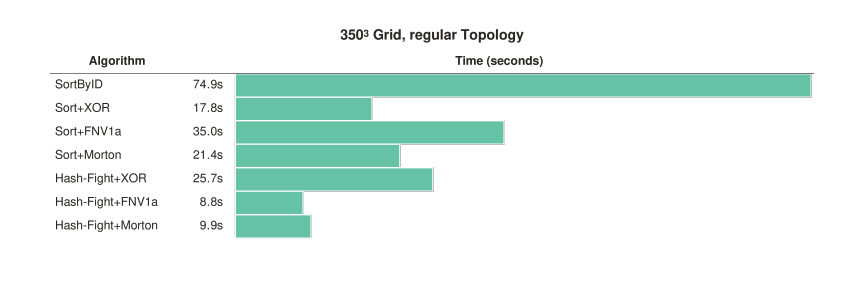

In [12]:
make_table(350, 'regular')

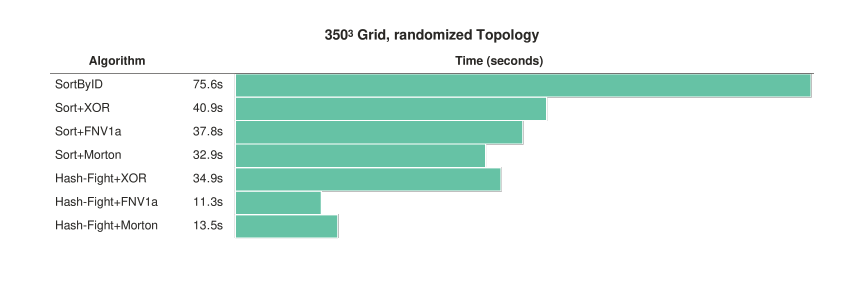

In [13]:
make_table(350, 'randomized')

The results for the largest grid are similar to that of the smallest one. The hash fight with FNV1A is the best performer, beating hash fight with morton encoding by a small margin. For the sorting approach, XOR is still working surprisingly well, especially for regular grids. The orientation in this case must generate very unique hashes.

Sorting based on Id3 is clearly the loser.

## Sorted hash behavior behavior

I'm curious about the behavior of the XOR hash compared to the others, particularly with respect to regular topology. Why is it so much faster? Let's take a look at the breakdown of the time for the Sort approach for XOR, FNV1A, and Morton on the largest grid.

In [14]:
pivot_data = \
    flat_data.pivot_table(values=['seconds-num-faces-per-cell',
                                  'seconds-face-input-count',
                                  'seconds-morton-codes',
                                  'seconds-face-hash',
                                  'seconds-keys-build-arrays',
                                  'seconds-face-count',
                                  'seconds-face-output-count',
                                  'seconds-points-per-face',
                                  'seconds-build-connectivity',],
                          columns=['size-x', 'topology-connections', 'full-name'],
                          aggfunc='mean')
pivot_data = pivot_data.swaplevel(0,1).swaplevel(1,2).swaplevel(2,3)
pivot_data[350]['regular']['Sort+XOR']

seconds-num-faces-per-cell     0.116038
seconds-face-input-count       0.760479
seconds-morton-codes                NaN
seconds-face-hash              0.948664
seconds-keys-build-arrays     11.161640
seconds-face-count             4.370924
seconds-face-output-count      0.089560
seconds-points-per-face        0.062139
seconds-build-connectivity     0.071566
dtype: float64

In [15]:
pivot_data[350]['regular']['Sort+FNV1a']

seconds-num-faces-per-cell     0.115758
seconds-face-input-count       0.760471
seconds-morton-codes                NaN
seconds-face-hash              1.075794
seconds-keys-build-arrays     29.599820
seconds-face-count             2.822169
seconds-face-output-count      0.300984
seconds-points-per-face        0.015799
seconds-build-connectivity     0.029145
dtype: float64

In [16]:
pivot_data[350]['regular']['Sort+Morton']

seconds-num-faces-per-cell     0.115752
seconds-face-input-count       0.753993
seconds-morton-codes           0.101966
seconds-face-hash              0.958018
seconds-keys-build-arrays     17.617850
seconds-face-count             1.315023
seconds-face-output-count      0.258092
seconds-points-per-face        0.016687
seconds-build-connectivity     0.029915
dtype: float64

So, it looks like all implementations are spending most of their time building the keys array, which involves sorting the array, identifying unique values in the array, compressing the array to unique instances, and computing the reverse lookup. Perhaps this is about data movement. In indices from a regular grid, the XOR hashes are probably in about the correct order, and a radix sort does not have to move data around much (I guess). (Either that or a "slow path" is being used and the merge sort is working better on a mostly presorted array.) The fact that the XOR hashes produce the longest seconds-face-count indicates that there is the most hash clashes there.

This might also indicate why the hash fight is running faster. The sort is (probably) taking the most time in the algorithm. The hash fight skips the sorting part of the algorithm.

## Trend Plots

Let us create trend plots of the algorithm behavior as we increase the size of the input.

In [17]:
pivot_data = \
    flat_data.pivot_table(index='num-input-cells',
                          columns=['topology-connections','full-name'],
                          values='seconds-total',
                          aggfunc='mean')

pivot_data

topology-connections       randomized                                   \
full-name            Hash-Fight+FNV1a Hash-Fight+Morton Hash-Fight+XOR   
num-input-cells                                                          
4851495                      0.495486          0.594297       1.693952   
10241915                     0.876275          1.593680       2.943017   
16539745                     1.255844          1.423362       3.791591   
26340120                     1.773106          2.128411       5.100436   
39402995                     2.460550          2.667807       9.089320   
56197120                     3.290186          6.594086      10.286580   
82906875                     4.661671          9.736123      19.042750   
102854120                    5.687718          6.692330      17.473050   
133654495                    7.195496          8.157950      25.607890   
170061120                    9.086332         10.781940      35.133940   
212542745                   11.277500         13.471530      34.909040   

topology-connections                                               \
full-name            Sort+FNV1a Sort+Morton   Sort+XOR   SortByID   
num-input-cells                                                     
4851495                1.490556    1.284482   1.365375   2.560596   
10241915               2.188653    1.821054   2.400223   3.968734   
16539745               3.527317    2.893390   3.752226   7.041264   
26340120               5.680652    4.362989   5.866252  10.765060   
39402995               8.210778    5.817592   7.578793  14.866980   
56197120               9.696913    8.594750  11.509770  19.476750   
82906875              14.590000   12.123500  15.672250  29.416820   
102854120             18.105110   14.529590  19.426290  32.370290   
133654495             23.886630   19.854010  25.363260  48.010130   
170061120             33.223450   25.063180  31.996520  66.208450   
212542745             37.765200   32.859510  40.874830  75.609770   

topology-connections          regular                                   \
full-name            Hash-Fight+FNV1a Hash-Fight+Morton Hash-Fight+XOR   
num-input-cells                                                          
4851495                      0.449068          0.497902       1.450015   
10241915                     0.789807          1.382244       2.116739   
16539745                     1.076397          1.166549       3.220150   
26340120                     1.589751          1.753702       4.152327   
39402995                     2.003640          2.134074       6.127893   
56197120                     2.765681          5.160638       7.335429   
82906875                     3.683638          7.155372       9.835029   
102854120                    4.561830          5.055728      12.239210   
133654495                    5.720451          6.099042      16.642660   
170061120                    7.190357          8.023520      19.272900   
212542745                    8.807724          9.863428      25.720120   

topology-connections                                               
full-name            Sort+FNV1a Sort+Morton   Sort+XOR   SortByID  
num-input-cells                                                    
4851495                1.458017    1.003613   0.811355   1.448298  
10241915               2.195232    1.582997   1.271395   2.529182  
16539745               3.127488    2.054376   1.784699   3.741841  
26340120               5.416914    3.066874   2.568232   5.736095  
39402995               8.005662    4.594779   3.670228   8.268528  
56197120              11.440230    6.205100   4.967962  11.640810  
82906875              12.927240    9.504826   6.952278  16.969680  
102854120             19.106490   10.406810   8.730318  21.100240  
133654495             26.173320   13.388330  11.294890  26.540760  
170061120             29.668550   14.487050  14.148230  44.961240  
212542745             34.979130   21.422540  17.805530  74.938990

In [18]:
grouped = flat_data.groupby(['topology-connections','full-name'])
#flat_data.loc[grouped.groups[('regular', 'Sort+Morton')]]

In [19]:
topology_connections = 'regular'
algorithms = ordered_names

canvas = toyplot.Canvas('8in', '4in')
axes = canvas.cartesian(bounds=(45,-15,6,-50),
                        xlabel='Number of Input Cells (Millions)',
                        ylabel='Time (seconds)')

# Help toyplot to size the area large enough for the labels
axes.x.domain.max = 250
axes.x.ticks.locator = toyplot.locator.Explicit([0,50,100,150,200])

# This is a hack to change the default colors used by the plots.
# Hopefully future versions of toyplot will make setting this easier
palette = toyplot.color.brewer.palette('Dark2')
import itertools
axes._palette = toyplot.color.brewer.palette('Dark2')
axes._plot_colors = itertools.cycle(palette)
axes._scatterplot_colors = itertools.cycle(palette)
axes._text_colors = itertools.cycle(palette)

for alg in algorithms:
    series = pivot_data[topology_connections][alg]
    x = series.index / 1000000.0
    y = numpy.array(series)
    axes.plot(x, y)

    # Correct label placement for coincident labels
    if alg == 'Hash-Fight+FNV1a':
        vert_align = 'top'
    elif alg == 'Hash-Fight+XOR':
        vert_align = 'first-baseline'
    elif alg == 'Sort+Morton':
        vert_align = 'first-baseline'
    else:
        vert_align = 'middle'
    axes.text(x[-1], y[-1], alg,
              style={'text-anchor':'start',
                     '-toyplot-anchor-shift':'5pt',
                     '-toyplot-vertical-align':vert_align})
    
    dataGroup = flat_data.loc[grouped.groups[(topology_connections, alg)]]
    x = dataGroup['num-input-cells']/ 1000000.0
    y = dataGroup['seconds-total']
    axes.scatterplot(x, y)

SortByID <path d="M 58.739433839999997 332.41348972111933 L 74.005103280000014 331.51393473310202 L 91.840557840000002 330.51022837452757 L 119.59521984 328.97812058995362 L 156.58928184000001 326.82329539411717 L 204.15024383999997 324.2857272716434 L 279.79227000000003 320.40562778552777 L 336.28286783999999 316.92887706120115 L 423.50952983999997 311.91415435609451 L 526.61309183999992 306.33477936354643 L 646.92105384000001 299.18335396024844" style="stroke:rgb(85.1%,37.3%,0.8%);stroke-opacity:1.0;stroke-width:2.0"> Sort+XOR <path d="M 58.739433839999997 331.14901708576264 L 74.005103280000014 329.70747877096971 L 91.840557840000002 327.88456043209209 L 119.59521984 323.40785377544086 L 156.58928184000001 318.34585771005476 L 204.15024383999997 311.6299588654004 L 279.79227000000003 308.72228350681399 L 336.28286783999999 296.63947776943166 L 423.50952983999997 282.82111242264904 L 526.61309183999992 275.98659608207845 L 646.92105384000001 265.6023736452409" style="stroke:rgb(45.9%,43.9%,70.2%);stroke-opacity:1.0;stroke-width:2.0"> Sort+FNV1a <path d="M 58.739433839999997 332.03755172586472 L 74.005103280000014 330.90463321052567 L 91.840557840000002 329.98290632042068 L 119.59521984 328.00308406958305 L 156.58928184000001 325.01544328790646 L 204.15024383999997 321.86664758975093 L 279.79227000000003 315.41441661599362 L 336.28286783999999 313.65069165742625 L 423.50952983999997 307.82067556127862 L 526.61309183999992 305.67225620297842 L 646.92105384000001 292.11071097280347" style="stroke:rgb(90.6%,16.1%,54.1%);stroke-opacity:1.0;stroke-width:2.0"> Sort+Morton Hash-Fight+XOR <path d="M 58.739433839999997 333.12189889711578 L 74.005103280000014 332.45562452814443 L 91.840557840000002 331.89523067568052 L 119.59521984 330.89142654791289 L 156.58928184000001 330.08211467610971 L 204.15024383999997 328.59203200152615 L 279.79227000000003 326.79707369651015 L 336.28286783999999 325.07987123081875 L 423.50952983999997 322.8143224237221 L 526.61309183999992 319.94009195073386 L 646.92105384000001 316.77751861787743" style="stroke:rgb(90.2%,67.1%,0.8%);stroke-opacity:1.0;stroke-width:2.0"> Hash-Fight+FNV1a <path d="M 58.739433839999997 333.02641065922671 L 74.005103280000014 331.29718238723751 L 91.840557840000002 331.71894890963506 L 119.59521984 330.57083940813868 L 156.58928184000001 329.82706613728226 L 204.15024383999997 323.90897173039548 L 279.79227000000003 320.00850105519191 L 336.28286783999999 324.11411105149574 L 423.50952983999997 322.07403169152627 L 526.61309183999992 318.31093846502364 L 646.92105384000001 314.71321205184148" style="stroke:rgb(65.1%,46.3%,11.4%);stroke-opacity:1.0;stroke-width:2.0"> Hash-Fight+Morton 0 50 100 150 200 Number of Input Cells (Millions) 0 50 100 150 Time (seconds)

In [20]:
toyplot.pdf.render(canvas, 'sizextime-knl-regular.pdf')

In [21]:
topology_connections = 'regular'
algorithms = ordered_names

canvas = toyplot.Canvas('4.5in', '2.7in')
axes = canvas.cartesian(bounds=(45,-15,6,-50),
                        xlabel='Number of Input Cells (Millions)',
                        ylabel='Time (seconds)')

# Help toyplot to size the area large enough for the labels
axes.x.domain.max = 300
axes.x.ticks.locator = toyplot.locator.Explicit([0,100,200])

# This is a hack to change the default colors used by the plots.
# Hopefully future versions of toyplot will make setting this easier
palette = toyplot.color.brewer.palette('Dark2')
import itertools
axes._palette = toyplot.color.brewer.palette('Dark2')
axes._plot_colors = itertools.cycle(palette)
axes._scatterplot_colors = itertools.cycle(palette)
axes._text_colors = itertools.cycle(palette)

for alg in algorithms:
    series = pivot_data[topology_connections][alg]
    x = series.index / 1000000.0
    y = numpy.array(series)
    axes.plot(x, y)

    # Correct label placement for coincident labels
    if alg == 'Sort+FNV1a':
        baseline_shift = '100%'
    elif alg == 'Hash-Fight+XOR':
        baseline_shift = '100%'
    elif alg == 'Sort+Morton':
        baseline_shift = '50%'
    elif alg == 'Hash-Fight+Morton':
        baseline_shift = '-20%'
    elif alg == 'Hash-Fight+FNV1a':
        baseline_shift = '-100%'
    else:
        baseline_shift = '0'
    axes.text(x[-1], y[-1], alg,
              style={'text-anchor':'start',
                     '-toyplot-anchor-shift':'5pt',
                     'baseline-shift':baseline_shift})
    
    dataGroup = flat_data.loc[grouped.groups[(topology_connections, alg)]]
    x = dataGroup['num-input-cells']/ 1000000.0
    y = dataGroup['seconds-total']
    axes.scatterplot(x, y)

<path d="M 51.015853800000002 207.44555475909434 L 57.699974599999997 206.13618901408114 L 65.509283800000006 204.66719312277186 L 77.661748799999998 202.25138543715943 L 93.859713799999994 199.18363624137064 L 114.68442880000001 195.09850727903563 L 147.80452500000001 188.64319862646207 L 172.53910880000001 183.63950371403701 L 210.73157379999998 177.04894402117534 L 255.87578880000001 154.73466652358977 L 308.55300380000006 118.42009533688636" style="stroke:rgb(10.6%,62%,46.7%);stroke-opacity:1.0;stroke-width:2.0"> SortByID <path d="M 51.015853800000002 208.21713753454711 L 57.699974599999997 207.65985224928758 L 65.509283800000006 207.03804391982928 L 77.661748799999998 206.08888446304445 L 93.859713799999994 204.75394397586768 L 114.68442880000001 203.18188957804247 L 147.80452500000001 200.77812062810744 L 172.53910880000001 198.62423115498802 L 210.73157379999998 195.51754928401951 L 255.87578880000001 192.0610584349775 L 308.55300380000006 187.63066318512952" style="stroke:rgb(85.1%,37.3%,0.8%);stroke-opacity:1.0;stroke-width:2.0"> Sort+XOR <path d="M 51.015853800000002 207.43378131654563 L 57.699974599999997 206.54073075079586 L 65.509283800000006 205.41141060914973 L 77.661748799999998 202.63803624137068 L 93.859713799999994 199.50206794720461 L 114.68442880000001 195.34148671173588 L 147.80452500000001 193.540146367636 L 172.53910880000001 186.05470086203812 L 210.73157379999998 177.49405501305574 L 255.87578880000001 173.25998879231201 L 308.55300380000006 166.82683635583214" style="stroke:rgb(45.9%,43.9%,70.2%);stroke-opacity:1.0;stroke-width:2.0"> Sort+FNV1a <path d="M 51.015853800000002 207.98423936187714 L 57.699974599999997 207.28238252554516 L 65.509283800000006 206.71136147655326 L 77.661748799999998 205.4848374479856 L 93.859713799999994 203.63395754909325 L 114.68442880000001 201.68324021413835 L 147.80452500000001 197.68600444015215 L 172.53910880000001 196.59335531947872 L 210.73157379999998 192.98158925015795 L 255.87578880000001 191.65061725745488 L 308.55300380000006 183.24907460266363" style="stroke:rgb(90.6%,16.1%,54.1%);stroke-opacity:1.0;stroke-width:2.0"> Sort+Morton <path d="M 51.015853800000002 207.44347481250969 L 57.699974599999997 206.63581592684002 L 65.509283800000006 205.2991613310918 L 77.661748799999998 204.1699368887935 L 93.859713799999994 201.77676755016631 L 114.68442880000001 200.31397757985476 L 147.80452500000001 197.28600175984548 L 172.53910880000001 194.37361500399422 L 210.73157379999998 189.03934547102094 L 255.87578880000001 185.85311442572521 L 308.55300380000006 178.04305430959448" style="stroke:rgb(40%,65.1%,11.8%);stroke-opacity:1.0;stroke-width:2.0"> Hash-Fight+XOR <path d="M 51.015853800000002 208.65600565821319 L 57.699974599999997 208.24324056133824 L 65.509283800000006 207.89606973566549 L 77.661748799999998 207.27420083699965 L 93.859713799999994 206.77282226276066 L 114.68442880000001 205.8496978741162 L 147.80452500000001 204.73769931442331 L 172.53910880000001 203.67387144543403 L 210.73157379999998 202.2703363307937 L 255.87578880000001 200.48971550118634 L 308.55300380000006 198.53046275351431" style="stroke:rgb(90.2%,67.1%,0.8%);stroke-opacity:1.0;stroke-width:2.0"> Hash-Fight+FNV1a <path d="M 51.015853800000002 208.59684953035017 L 57.699974599999997 207.52557152770322 L 65.509283800000006 207.78686103182267 L 77.661748799999998 207.0755931943103 L 93.859713799999994 206.614816582609 L 114.68442880000001 202.94848492565964 L 147.80452500000001 200.53209577565545 L 172.53910880000001 203.07557123678026 L 210.73157379999998 201.81171719426257 L 255.87578880000001 199.48043504906343 L 308.55300380000006 197.25159966138472" style="stroke:rgb(65.1%,46.3%,11.4%);stroke-opacity:1.0;stroke-width:2.0"> Hash-Fight+Morton 0 100 200 Number of Input Cells (Millions) 0 50 100 150 Time (seconds)

In [22]:
toyplot.pdf.render(canvas, 'sizextime-knl-regular-small.pdf')

In [23]:
topology_connections = 'randomized'
algorithms = ordered_names

canvas = toyplot.Canvas('8in', '4in')
axes = canvas.cartesian(bounds=(45,-15,6,-50),
                        xlabel='Number of Input Cells (Millions)',
                        ylabel='Time (seconds)')

# Help toyplot to size the area large enough for the labels
axes.x.domain.max = 250
axes.x.ticks.locator = toyplot.locator.Explicit([0,50,100,150,200])

# This is a hack to change the default colors used by the plots.
# Hopefully future versions of toyplot will make setting this easier
palette = toyplot.color.brewer.palette('Dark2')
import itertools
axes._palette = toyplot.color.brewer.palette('Dark2')
axes._plot_colors = itertools.cycle(palette)
axes._scatterplot_colors = itertools.cycle(palette)
axes._text_colors = itertools.cycle(palette)

for alg in algorithms:
    series = pivot_data[topology_connections][alg]
    x = series.index / 1000000.0
    y = numpy.array(series)
    axes.plot(x, y)

    # Correct label placement for coincident labels
    if alg == 'Hash-Fight+FNV1a':
        vert_align = 'top'
    elif alg == 'Sort+Morton':
        vert_align = 'top'
    else:
        vert_align = 'middle'
    axes.text(x[-1], y[-1], alg,
              style={'text-anchor':'start',
                     '-toyplot-anchor-shift':'5pt',
                     '-toyplot-vertical-align':vert_align})
    
    dataGroup = flat_data.loc[grouped.groups[(topology_connections, alg)]]
    x = dataGroup['num-input-cells']/ 1000000.0
    y = dataGroup['seconds-total']
    axes.scatterplot(x, y)

<path d="M 58.739433839999997 327.00103759999996 L 74.005103280000014 323.15212706666671 L 91.840557840000002 314.75387839999996 L 119.59521984 304.57550266666664 L 156.58928184000001 293.36358799999999 L 204.15024383999997 280.76355000000001 L 279.79227000000003 253.59402533333332 L 336.28286783999999 245.52120733333331 L 423.50952983999997 202.77231133333336 L 526.61309183999992 153.03023666666664 L 646.92105384000001 127.33329533333335" style="stroke:rgb(10.6%,62%,46.7%);stroke-opacity:1.0;stroke-width:2.0"> SortByID Sort+XOR <path d="M 58.739433839999997 329.92581360000003 L 74.005103280000014 328.01768179999993 L 91.840557840000002 324.35866686666668 L 119.59521984 318.47288453333329 L 156.58928184000001 311.55720680000002 L 204.15024383999997 307.4951044666667 L 279.79227000000003 294.12066666666664 L 336.28286783999999 284.51269933333333 L 423.50952983999997 268.70987799999995 L 526.61309183999992 243.18923666666669 L 646.92105384000001 230.77511999999999" style="stroke:rgb(45.9%,43.9%,70.2%);stroke-opacity:1.0;stroke-width:2.0"> Sort+FNV1a <path d="M 58.739433839999997 330.48908253333332 L 74.005103280000014 329.02245239999996 L 91.840557840000002 326.09140066666669 L 119.59521984 322.07449673333332 L 156.58928184000001 318.09858186666662 L 204.15024383999997 310.50768333333332 L 279.79227000000003 300.86243333333334 L 336.28286783999999 294.2857873333333 L 423.50952983999997 279.73237266666666 L 526.61309183999992 265.49397466666665 L 646.92105384000001 244.18400600000001" style="stroke:rgb(90.6%,16.1%,54.1%);stroke-opacity:1.0;stroke-width:2.0"> Sort+Morton <path d="M 58.739433839999997 329.36986453333338 L 74.005103280000014 325.95575353333334 L 91.840557840000002 323.63631793333337 L 119.59521984 320.05880826666669 L 156.58928184000001 309.15585866666669 L 204.15024383999997 305.88334799999996 L 279.79227000000003 281.94981666666666 L 336.28286783999999 286.24032999999997 L 423.50952983999997 264.00510066666664 L 526.61309183999992 237.96723066666667 L 646.92105384000001 238.58195733333335" style="stroke:rgb(40%,65.1%,11.8%);stroke-opacity:1.0;stroke-width:2.0"> Hash-Fight+XOR <path d="M 58.739433839999997 332.6456718733333 L 74.005103280000014 331.60484860666668 L 91.840557840000002 330.56735973333332 L 119.59521984 329.15351026666667 L 156.58928184000001 327.27449666666661 L 204.15024383999997 325.00682493333335 L 279.79227000000003 321.25809926666665 L 336.28286783999999 318.45357080000002 L 423.50952983999997 314.33231093333336 L 526.61309183999992 309.16402586666669 L 646.92105384000001 303.17483333333331" style="stroke:rgb(90.2%,67.1%,0.8%);stroke-opacity:1.0;stroke-width:2.0"> Hash-Fight+FNV1a <path d="M 58.739433839999997 332.37558820000004 L 74.005103280000014 329.64394133333332 L 91.840557840000002 330.10947720000001 L 119.59521984 328.18234326666669 L 156.58928184000001 326.70799419999997 L 204.15024383999997 315.97616493333334 L 279.79227000000003 307.38793046666666 L 336.28286783999999 315.70763133333332 L 423.50952983999997 311.70160333333331 L 526.61309183999992 304.52936400000004 L 646.92105384000001 297.17781800000006" style="stroke:rgb(65.1%,46.3%,11.4%);stroke-opacity:1.0;stroke-width:2.0"> Hash-Fight+Morton 0 50 100 150 200 Number of Input Cells (Millions) 0 40 80 120 Time (seconds)

In [24]:
toyplot.pdf.render(canvas, 'sizextime-knl-randomized.pdf')

In [25]:
topology_connections = 'randomized'
algorithms = ordered_names

canvas = toyplot.Canvas('4.5in', '2.7in')
axes = canvas.cartesian(bounds=(45,-15,6,-50),
                        xlabel='Number of Input Cells (Millions)',
                        ylabel='Time (seconds)')

# Help toyplot to size the area large enough for the labels
axes.x.domain.max = 300
axes.x.ticks.locator = toyplot.locator.Explicit([0,100,200])

# This is a hack to change the default colors used by the plots.
# Hopefully future versions of toyplot will make setting this easier
palette = toyplot.color.brewer.palette('Dark2')
import itertools
axes._palette = toyplot.color.brewer.palette('Dark2')
axes._plot_colors = itertools.cycle(palette)
axes._scatterplot_colors = itertools.cycle(palette)
axes._text_colors = itertools.cycle(palette)

for alg in algorithms:
    series = pivot_data[topology_connections][alg]
    x = series.index / 1000000.0
    y = numpy.array(series)
    axes.plot(x, y)

    # Correct label placement for coincident labels
    #if alg == 'Hash-Fight+FNV1a':
    #    vert_align = 'top'
    #elif alg == 'Sort+Morton':
    #    vert_align = 'top'
    #else:
    #    vert_align = 'middle'
    vert_align = 'middle'
    if alg == 'Sort+XOR':
        label = 'Sort+XOR<br/>&#160;<br/>&#160;'
    elif alg == 'Sort+FNV1a':
        label = 'Sort+FNV1a<br/>&#160;'
    elif alg == 'Sort+Morton':
        label = '&#160;<br/>Sort+Morton'
    elif alg == 'Hash-Fight+FNV1a':
        label = '&#160;<br/>Hash-Fight+FNV1a'
    else:
        label = alg
    axes.text(x[-1], y[-1], label,
              style={'text-anchor':'start',
                     '-toyplot-anchor-shift':'5pt',
                     '-toyplot-vertical-align':vert_align})
    
    dataGroup = flat_data.loc[grouped.groups[(topology_connections, alg)]]
    x = dataGroup['num-input-cells']/ 1000000.0
    y = dataGroup['seconds-total']
    axes.scatterplot(x, y)

SortByID <path d="M 51.015853800000002 206.88796499999998 L 57.699974599999997 205.13562238666665 L 65.509283800000006 202.84623063999999 L 77.661748799999998 199.26647994666666 L 93.859713799999994 196.36657718666666 L 114.68442880000001 189.71012280000002 L 147.80452500000001 182.66165666666666 L 172.53910880000001 176.30481559999998 L 210.73157379999998 166.2515464 L 255.87578880000001 155.01922613333332 L 308.55300380000006 139.98528786666665" style="stroke:rgb(85.1%,37.3%,0.8%);stroke-opacity:1.0;stroke-width:2.0"> Sort+XOR     <path d="M 51.015853800000002 206.67599183999999 L 57.699974599999997 205.49388091999998 L 65.509283800000006 203.22707654666664 L 77.661748799999998 199.58076261333329 L 93.859713799999994 195.29641591999999 L 114.68442880000001 192.77989398666668 L 147.80452500000001 184.49426666666665 L 172.53910880000001 178.54201373333333 L 210.73157379999998 168.75197319999998 L 255.87578880000001 152.94162466666666 L 308.55300380000006 145.25092799999999" style="stroke:rgb(45.9%,43.9%,70.2%);stroke-opacity:1.0;stroke-width:2.0"> Sort+FNV1a   <path d="M 51.015853800000002 207.02494381333332 L 57.699974599999997 206.11634856000001 L 65.509283800000006 204.30052626666665 L 77.661748799999998 201.81200529333333 L 93.859713799999994 199.34887754666667 L 114.68442880000001 194.64622333333332 L 147.80452500000001 188.6708733333333 L 172.53910880000001 184.59656093333331 L 210.73157379999998 175.58054306666668 L 255.87578880000001 166.75968186666665 L 308.55300380000006 153.5578964" style="stroke:rgb(90.6%,16.1%,54.1%);stroke-opacity:1.0;stroke-width:2.0">   Sort+Morton Hash-Fight+XOR <path d="M 51.015853800000002 208.3609772093333 L 57.699974599999997 207.71617450266666 L 65.509283800000006 207.07343749333333 L 77.661748799999998 206.19754050666666 L 93.859713799999994 205.03346866666666 L 114.68442880000001 203.62861837333332 L 147.80452500000001 201.30623710666666 L 172.53910880000001 199.56879751999998 L 210.73157379999998 197.01562677333331 L 255.87578880000001 193.81381114666667 L 308.55300380000006 190.1034333333333" style="stroke:rgb(90.2%,67.1%,0.8%);stroke-opacity:1.0;stroke-width:2.0">   Hash-Fight+FNV1a <path d="M 51.015853800000002 208.19365708000001 L 57.699974599999997 206.50136853333331 L 65.509283800000006 206.78977368 L 77.661748799999998 205.59589070666667 L 93.859713799999994 204.68251347999998 L 114.68442880000001 198.03401437333335 L 147.80452500000001 192.71349838666666 L 172.53910880000001 197.86765453333334 L 210.73157379999998 195.38587133333331 L 255.87578880000001 190.94258159999998 L 308.55300380000006 186.38820920000001" style="stroke:rgb(65.1%,46.3%,11.4%);stroke-opacity:1.0;stroke-width:2.0"> Hash-Fight+Morton 0 100 200 Number of Input Cells (Millions) 0 40 80 120 Time (seconds)

In [26]:
toyplot.pdf.render(canvas, 'sizextime-knl-randomized-small.pdf')

## Compare regular to randomized

For some "representative size," which is large but following the trend of sizes, compare the regular vs randomized times.

In [27]:
representative_mesh_size = 300
# The 300^3 mesh has 133,654,495 tetrahedra

In [28]:
ordered_connections = ['regular', 'random']

# Average all time values for each algorithm on regular/random representative mesh
pivot_data = \
    flat_data.pivot_table(columns='size-x',
                          index=['full-name','topology-connections'],
                          values='seconds-total',
                          aggfunc='mean')

pivot_data.reset_index(inplace=True)

# Changed randomized to random to fit better.
pivot_data['topology-connections'][pivot_data['topology-connections'] == 'randomized'] = 'random'

# Sort the rows in the order we want to show them.
pivot_data['full-name'] = pandas.Categorical(pivot_data['full-name'], ordered_names)
pivot_data['topology-connections'] = pandas.Categorical(pivot_data['topology-connections'], ordered_connections)
pivot_data.sort_values(['full-name', 'topology-connections'], inplace=True)

# Changed randomized to random to fit better.
pivot_data['topology-connections'][pivot_data['topology-connections'] == 'randomized'] = 'random'

# Create a table with the values we want
table_data = pandas.DataFrame({'Algorithm':pivot_data['full-name'],
                               'Mesh':pivot_data['topology-connections'],
                               'Seconds':pivot_data[representative_mesh_size],
                               'Bars':pivot_data[representative_mesh_size]})
table_data = table_data[['Algorithm', 'Mesh', 'Seconds', 'Bars']]

table_data

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,Algorithm,Mesh,Seconds,Bars
13,SortByID,regular,26.540760,26.540760
12,SortByID,random,48.010130,48.010130
11,Sort+XOR,regular,11.294890,11.294890
10,Sort+XOR,random,25.363260,25.363260
7,Sort+FNV1a,regular,26.173320,26.173320
6,Sort+FNV1a,random,23.886630,23.886630
9,Sort+Morton,regular,13.388330,13.388330
8,Sort+Morton,random,19.854010,19.854010
5,Hash-Fight+XOR,regular,16.642660,16.642660
4,Hash-Fight+XOR,random,25.607890,25.607890


In [29]:
canvas = toyplot.Canvas(width='4.5in', height='3in')
table = canvas.table(table_data,
                     bounds=(0,-1,1,-1))

table.top.cell[0,2:4].merge().data = 'Time (seconds)'
table.cells.column[0].align = 'left'
table.cells.column[1].align = 'left'
table.body.column[2].format = toyplot.format.FloatFormatter('{:.1f}s')

axes = table.body.column[3].cartesian()
axes.cell_bars(width=1.0)

# I hate gridlines, but they are useful for sizing columns
#table.cells.grid.vlines[...] = 'single'

table.cells.column[0].width = '1.15in'
table.cells.column[1].width = '0.6in'
table.cells.column[2].width = '0.4in'

table.body.gaps.rows[range(1,12,2)] = '0.075in'

Algorithm Mesh SortByID regular 26 . 5s SortByID random 48 . 0s Sort+XOR regular 11 . 3s Sort+XOR random 25 . 4s Sort+FNV1a regular 26 . 2s Sort+FNV1a random 23 . 9s Sort+Morton regular 13 . 4s Sort+Morton random 19 . 9s Hash-Fight+XOR regular 16 . 6s Hash-Fight+XOR random 25 . 6s Hash-Fight+FNV1a regular 5 . 7s Hash-Fight+FNV1a random 7 . 2s Hash-Fight+Morton regular 6 . 1s Hash-Fight+Morton random 8 . 2s Time (seconds)

In [30]:
toyplot.pdf.render(canvas, 'reg-vs-rand-knl.pdf')